# Cosmology Calculator

### Noah Franz

Before doing anything else import everything we need

In [1]:
from dataclasses import dataclass
import numpy as np
from scipy.integrate import quad 
import matplotlib.pyplot as plt
import seaborn as sns

First we need to define some useful base classes to be used throughout

In [2]:
@dataclass
class Unit:
    '''
    A string representation of Units

    SUPER rudimentary but will keep track of them for us for now at least!
    '''

    # the string representation of the unit
    # There must be spaces between individual units
    # for example 'm s^-2' is valid but 'ms^-2' is not
    value: str  

    def __repr__(self):
        return self.value

    def __add__(self, other):
        return Unit(self.unit + other.unit)

    def __len__(self):
        return len(self.value)

In [3]:
class Value:
    '''
    A number with a unit. 
    
    Handles combining units so we can check things later!
    This is much less pretty than astropy units but should be
    good enough to help us convert later on!
    '''
    def __init__(self, value: float | int, unit: Unit=None):
        
        if unit is None:
            unit = Unit('') # assume it has no units
        
        if isinstance(unit, str):
            unit = Unit(unit)
        
        self.value = value
        self.unit = unit
    
    def __add__(self, other):
        if other.unit != self.unit:
            raise ValueError('Can not add values with different units!')
        
        return Value(self.value + other.value, self.unit)
    
    def __mul__(self, other):
        if len(other.unit) == 0:
            outunit = self.unit
        else:
            outunit = self.unit.value+' '+other.unit.value
        return Value(self.value * other.value, outunit)
    
    def __neg__(self):
        return Value(-self.value, self.unit)
    
    def __pow__(self, p:int):
        if len(self.unit) == 0:
            outunit = ''
        else:
            outunit = '('+self.unit.value+f')^{p}'
        return Value(self.value**p, outunit)
    
    def __sub__(self, other):
        return self + -other
    
    def __truediv__(self, other):
        if len(other.unit) == 0:
            outunit = self.unit.value
        else:
            outunit = self.unit.value + ' (' + other.unit.value + ')^-1'
        return Value(self.value / other.value, outunit)
    
    def __repr__(self):
        return f'{self.value} {self.unit}'
    
    def __array__(self):
        # make it so numpy functions work
        return np.array(self.value)   
    
    def __getitem__(self, idx):
        return Value(self.value[idx], self.unit)

    def __cmp__(self, other):
        if isinstance(other, float) or isinstance(other, int):
            return self.value - other
        else:
            return self.value - other.value

In [4]:
class Constants:
    c:Value = Value(3e8, 'm s^-1')
    jy_to_cgs:Value = Value(1e-23, 'erg cm^−2 s^−1 Hz^−1')

Now we can write the calculator. The general idea is that we want users (me for this project) to give the calculator their chosen "cosmology" and then the code calculates things for them!

In [5]:
class CosmoCalc:
    
    def __init__(self, H0:Value, omega_m:Value, omega_lambda:Value, verbose=False):
        # This defines the "cosmology" we are working in
        
        if not isinstance(H0, Value):
            H0 = Value(H0, 'km s^-1 Mpc^-1') # assume units...
        
        if not isinstance(omega_m, Value):
            omega_m = Value(omega_m)
            
        if not isinstance(omega_lambda, Value):
            omega_lambda = Value(omega_lambda)
        
        self.H0 = H0
        self.omega_m = omega_m
        self.omega_lambda = omega_lambda
        
        # compute some other important values from the inputs
        self.omega_k = Value(1) - self.omega_m - self.omega_lambda 

        # we can determine k based on the sign of omega_k
        # since c^2, H0^2, and Rc^2 are always positive
        if self.omega_k.value > 0:
            self.k = Value(-1)
        elif self.omega_k.value < 0:
            self.k = Value(1)
        else: # equal to 0
            self.k = Value(0)
        
        try:
            self.R_c = (-self.k * Constants.c**2 / (self.H0**2 * self.omega_k))**(1/2)
        except ZeroDivisionError:
            self.R_c = Value(np.inf)

        if verbose:
            # check some values
            print(f'H0 = {H0}')
            print(f'k = {self.k}')
            print(f'omega_k = {self.omega_k}')
            print(f'R_c = {self.R_c}')
            
    def __repr__(self):
        return f'CosmoCalc($H_0$={self.H0}, $\Omega_m$={self.omega_m}, $\Omega_\Lambda$={self.omega_lambda})'
        
    def H(self, z):
        '''
        Hubble constant as a function of z
        '''
        val1 = self.omega_m.value*(1+z)**3 # this is unitless so it's safe to take the value
        val2 = self.omega_k.value*(1+z)**2 # this is unitless so it's safe to take the value
        val3 = self.omega_lambda.value # unitless
        out = self.H0 * Value((val1 + val2 + val3)**(1/2))
        return out

    def _integrand_comoving_distance(self, z):
        '''
        Private method to be integrated over
        '''
        i = Constants.c / self.H(z)
        return i
    
    def comoving_distance(self, z, **kwargs):
        '''
        compute the comoving distance
        '''
        
        if not isinstance(z, np.ndarray):
            if isinstance(z, list):
                z = np.array(z)
            else:
                z = np.array([z])
        
        results = []
        for zz in z:
            zarr = np.linspace(0, zz, **kwargs)
            I = self._integrand_comoving_distance(zarr)
            #import pdb; pdb.set_trace()
            res = np.trapz(I.value, zarr)
            results.append(res)
        
        return Value(np.array(results), I.unit)

    def D(self, z):
        '''
        Compute the D factor for other distance measures
        '''
        r = self.comoving_distance(z)

        if np.isfinite(self.R_c):
            D = self.R_c * Value(np.sinh(r/self.R_c), (r/self.R_c).unit)
        else:
            D = r # for flat universe

        return D
    
    def luminosity_distance(self, z):
        '''
        compute the luminosity distance
        '''
        return self.angular_diameter_distance(z) * Value((1+z)**2)
        
    def angular_diameter_distance(self, z):
        '''
        Compute the angular diameter distance
        '''
        D = self.D(z)
        return D/Value(1+z)
        
    def comoving_volume(self, z):
        '''
        Find the comoving volume
        '''
        D = self.D(z)
        return D**2 * Constants.c / self.H(z)
    
    def distance_modulus(self, z):
        '''
        Compute the distance modulus
        '''
        dL = self.luminosity_distance(z)
        
        # need to convert to pc
        # I don't feel like writing a unit converter so I'm gonna hardcode this
        # NOTE: THIS COULD CAUSE PROBLEMS LATER, BE CAUTIOUS
        # Assuming dL is in the following nightmare unit
        #  m s^-1 (km s^-1 Mpc^-1)^-1
        dL_pc = (dL.value*1e-3)*1e6
        
        return 5*np.log10(dL_pc/10)
    
    def look_back_time(self, z):
        '''
        Calculate the look-back time
        '''
        integrand = lambda z: Value(1) / (self.H(z) * Value(1+z))
        
        results = []
        for zz in z:
            zarr = np.linspace(0, zz)
            I = integrand(zarr)
            res = np.trapz(I.value, zarr)
            results.append(res)
        
        return Value(np.array(results), I.unit)

    def age_of_universe(self, z):
        '''
        Calculate the look-back time
        '''
        integrand = lambda z: 1 / (self.H(z).value * (1+z))
        
        results = []
        for zz in z:
            res, err = quad(integrand, zz, np.inf)
            results.append(res)
        
        return Value(np.array(results), f'{self.H(zz).unit}^-1')
    
    def luminosity(self, z, flux):
        '''
        Calculate the luminosity for this cosmology from the redshift and measured flux
        '''
        d = self.luminosity_distance(z)
        return Value(4*np.pi)*d**2*flux / Value(1+z)

    def proper_distance(self, z, dz=None):
        '''
        Computes the proper distance between two objects.
        Default is between us and the other object but can change this.

        Args:
            z [float]: redshift
            dz [float]: redshift difference, default is set to z for proper 
                        distance from earth to a source
        '''
        if dz is None:
            dz = z # it's just the redshift from us
        
        da = self.comoving_distance(dz) # comoving distance between the two objects
        
        a0 = 1 # acceleration factor on earth, by common practice
        a = Value(a0/(1+z)) # the expansion factor at z with respect to earth

        # now we can compute the proper distance
        d = a*r
        return d
        

# Using the Calculator to Solve Problems

First we need to setup the three given cosmologies

In [6]:
# construct calculators with our cosmologies
oms = [1, 0.3, 0.3]
ols = [0, 0, 0.7]
calculators = [CosmoCalc(70, om, ol) for om, ol in zip(oms, ols)]

# Problem 1
Produce plots of r(z), the angular diameter distance, the distance modulus
[5 log10(dL/10 pc)], the comoving volume per square degree per unit redshift, and the age of the
universe t(z), all as a function of redshift (say, between 0.1 and 5). Do this for three cosmologies:
Ωm, ΩΛ) = (1, 0), (0.3, 0), and (0.3, 0.7). Assuming H0 = 70 for problems 1, 2 and 3.
Interpret your findings, e.g. what are the trends between the cosmologies.

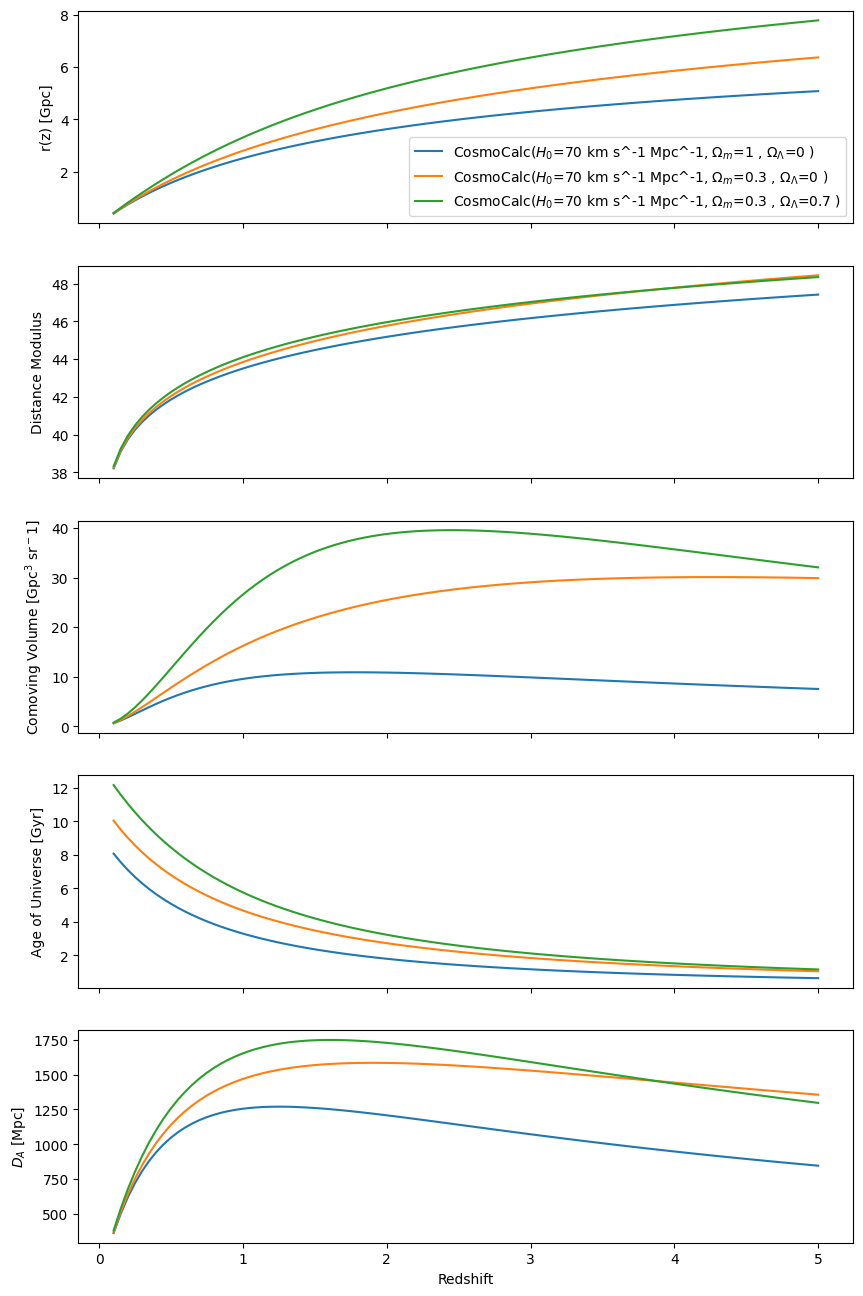

In [7]:
# create an array of redshifts to use
# the calculator should be vectorized so using numpy we can just 
# pass this in to all the relevant methods to get numpy arrays out
z = np.linspace(0.1, 5, 100)

# now we can calculate and plot everything
fig, ax = plt.subplots(5, 1, figsize=(10,16), sharey=False, sharex=True)

for ii, cc in enumerate(calculators):
    # first r(z)
    r_weird_units = cc.comoving_distance(z)
    r = Value(r_weird_units.value * 1e-6, 'Gpc') # converts to Gpc
    ax[0].plot(z, r, '-', label=cc)
    
    # then distance modulus
    D = cc.distance_modulus(z)
    ax[1].plot(z, D)
    
    # then comoving volume
    V_weird_units = cc.comoving_volume(z) # these units simplify to m^3 km^-3 Mpc^3
    V = Value(V_weird_units.value*1e-18, r'Gpc$^3$ sr$^-1$') # convert m^3 to km^3 to cancel those terms, then convert Mpc to Gpc
    
    ax[2].plot(z, V)
    
    # then t(z)
    f_weird_units = cc.age_of_universe(z)
    f_s = Value(f_weird_units.value*3.086e19, 's') # convert from s * Mpc / km to s (ie from Mpc to km to divide them out)
    f = Value((f_s.value/60/60/24/365)*1e-9 , 'Gyr') # convert from seconds to Myrs
    ax[3].plot(z, f)

    # then D_A
    da = Value(cc.angular_diameter_distance(z).value*1e-3, 'Mpc')
    ax[4].plot(z, da)

# label the plots
ax[0].set_ylabel(f'r(z) [{r.unit}]')
ax[1].set_ylabel(f'Distance Modulus')
ax[2].set_ylabel(f'Comoving Volume [{V.unit}]')
ax[3].set_ylabel(f'Age of Universe [{f.unit}]')
ax[4].set_ylabel(f'$D_A$ [{da.unit}]')

ax[-1].set_xlabel('Redshift') # set the x label once for each column

ax[0].legend();

Between cosmologies, the general shape of the curves appears the same. For exame $D_A$ rises to a peak and then declines for all cosmologies. Or, the age of the universe constantly decreases at a decreasing rate. This makes sense because we are not directly changing the physics between cosmologies, just the constants. It makes sense that both the comoving distance and distance modulus increase at a decreasing rate over redshift because at high redshift the distances between objects became smaller. Similarly, it makes sense that the age of the universe decreases at a decreasing rate since the universe is as old as it ever has been in this moment at z=0 (from our perspective at least). 

It is interesting though that for all parameters, the cosmology with the greatest value of any parameter is almost always (until high redshift) with $\Omega_m = 0.3$ and $\Omega_\Lambda = 0.7$. This is then followed by the cosmology with  $\Omega_m = 0.3$ and $\Omega_\Lambda = 0$. And, finally, the cosmology with the smallest values for every parameter at almost every redshift seems to be  $\Omega_m = 1$ and $\Omega_\Lambda = 0$.

# Problem 2

magine that we have a galaxy at z ≈ 0 that is 10th magnitude in R at a
distance of 7 Mpc. If the identical galaxy were at z = 1.75, what would K magnitude be in each
of the three cosmologies in Problem 1?

At z = 1.75, the light that was emitted in the R band has been shifted to the K band. Imagine
that the two bands have the same fractional width, i.e. that the filter response as a function of
frequency in the two bands is simply rescaled, fK (ν) = fR(2.75ν). That means that the flux in the
emitted R band can be easily related to that in the observed K band without knowledge of the
spectrum of the object.

The flux per unit frequency of a 0th magnitude star are roughly Fν = 3080 Janskies for the R
band and Fν = 640 Janskies for the K band. 1 Jansky is 10−23 erg cm−2 s−1 Hz−1. Please note
that this is flux per unit frequency; it is not the total flux received through the bandpass. Irrelevant
note in case you’re interested in the fine technical details of photometric definitions: this is the amplitude of a spectrum with a constant flux per unit frequency that would give the same response
in the detector as the calibrating m = 0 star.

t is almost a truism in cosmology that there is always one more factor of 1 + z that one has
forgotten. You’ll need to think carefully about what the quantities in this problem mean to be sure
that your answer isn’t off by a factor of 2.75!

General note: in this case, by construction, we could map the light in emitted in one band to
that received in another band. In most cases, we’re not this lucky: the two bands don’t overlap. In
this case, one has to correct the flux based on the details of the spectrum of source and the filter
responses of the band passes. This is known as a K correction. These apply even if the emitted
band and the observed band are the same: because the photons are redshifted, the two bands are
not probing the identical part of the object’s spectrum! A pedagogical explanation of K corrections
is given by Hogg et al. (astro-ph/0210394).

In [8]:
# two useful functions to go from magnitude to flux and back
def mag_to_flux(mag, ref):
    p = -mag/Value(2.5)
    exp = Value(10**(p.value))
    return ref * exp

def flux_to_mag(flux, ref):
    log = flux.value / ref.value # these must be given in the same units!
    return Value(-2.5*np.log10(log)) # we know this is unitless 

In [9]:
# some givens
R_ref = Value(3080, 'Jy')
K_ref = Value(640, 'Jy')
z = 1.75
m = Value(10) # magnitude at 7 Mpc in R
d_i = Value(7, 'Mpc') # distance at magnitude measurement

# First convert mag to flux in R and then get the luminosity. 
flux = mag_to_flux(m, R_ref)
L_weird_units = Value(4*np.pi)*d_i**2 * flux * Constants.jy_to_cgs
L_no_correction = Value(L_weird_units.value*(3.086e+24)**2, 'erg s^-1 Hz^-1') # convert from Mpc^2 to cm^2 in the numerator

#We also need to multiply L by 1+z to conserve total energy.
L = L_no_correction*Value(1+z)

# this is where we need to start assuming a cosmology
for cc in calculators:
    # Convert back to a flux in K band at z=1.75
    dl_weird_units = cc.luminosity_distance(z)[0] # we need to get the luminosity distance at z=1.75
    dl = Value(dl_weird_units.value*1e-3, 'Mpc') # simplify the units
    f2 = L/(Value(4*np.pi)*dl**2)
    f2 = Value(f2.value/3.086e24, 'Jy') # convert to Jy
    
    # Convert that flux to a magnitude
    m_K = flux_to_mag(f2, K_ref)
    print(f'{cc}: $m_K$={m_K.value:.2f}')

CosmoCalc($H_0$=70 km s^-1 Mpc^-1, $\Omega_m$=1 , $\Omega_\Lambda$=0 ): $m_K$=19.10
CosmoCalc($H_0$=70 km s^-1 Mpc^-1, $\Omega_m$=0.3 , $\Omega_\Lambda$=0 ): $m_K$=19.64
CosmoCalc($H_0$=70 km s^-1 Mpc^-1, $\Omega_m$=0.3 , $\Omega_\Lambda$=0.7 ): $m_K$=19.85


So, across cosmologies, the K-band magnitude of the object is nearly similar. It makes sense that the apparent brightness of this object decreases because, as shown in the plot above, the ca distance increases as we go down the above list. 

# Problem 3

If the number density of such galaxies is 0.01 Mpc−3 in the local universe
and if the galaxies are not changing, how many of these galaxies would be predicted in a 1 square
degree survey between z = 1.7 and z = 1.8? Compute this for all three cosmologies in Problem 1.
You need not do the integral between z = 1.7 and z = 1.8 more accurately than the width in
redshift times the value of the integrand at the central value.

In [10]:
n = Value(0.01, 'Mpc^-3')
omega = Value(1, 'deg^2')

zarr = np.linspace(1.7, 1.8, 1000)
for cc in calculators:
    V_dz_dOmega = cc.comoving_volume(zarr)
    V_dz = V_dz_dOmega * omega # omega is constant

    # integrate over the redshifts
    V = Value(np.trapz(V_dz.value, zarr), V_dz.unit)

    # now we need to multiple the number density by V to get a number
    N_weird_units = n*V # in weird units

    # convert N to steradian
    N_sr = N_weird_units*Value((np.pi/180)**2)

    N = Value(N_sr.value*Value(1e-9))
    
    print(f'{cc}: {N.value} galaxies')

CosmoCalc($H_0$=70 km s^-1 Mpc^-1, $\Omega_m$=1 , $\Omega_\Lambda$=0 ): 3315.3619573212777 galaxies
CosmoCalc($H_0$=70 km s^-1 Mpc^-1, $\Omega_m$=0.3 , $\Omega_\Lambda$=0 ): 7281.075028866473 galaxies
CosmoCalc($H_0$=70 km s^-1 Mpc^-1, $\Omega_m$=0.3 , $\Omega_\Lambda$=0.7 ): 11418.051159048246 galaxies


# Problem 4

Consider two galaxies at z ≈ 1.75 that are separated by 40′′ on the sky and
∆z = 0.003 in redshift. Assuming that the redshift difference is strictly cosmological (probably not
a good assumption as we’ll learn later), what is the proper (not comoving) separation between the
galaxies. Again, do this for all three cosmologies in Problem 1.

In [11]:
z = 1.75
dz = 0.003
ang_dist_deg = Value(40/3600, 'deg')
ang_dist = Value(ang_dist_deg.value*np.pi/180) # this is radians but we can just treat it like a geometric factor

for cc in calculators:
    
    # first get the proper distance
    d1_weird_units = cc.proper_distance(1.75, dz=0.003)[0]
    d1 = Value(d1_weird_units.value*1e-3, 'Mpc') # convert the units

    # then we need the angular distance
    da_weird_units = cc.angular_diameter_distance(1.75)[0]
    da = Value(da_weird_units.value*1e-3, 'Mpc')
    d2 = da*ang_dist
    
    # true distance between the galaxies
    d = Value(((d1**2 + d2**2)**(1/2)).value, 'Mpc')
    
    print(f'{cc}: {d.value:.4f} {d.unit}')

CosmoCalc($H_0$=70 km s^-1 Mpc^-1, $\Omega_m$=1 , $\Omega_\Lambda$=0 ): 0.2400 Mpc
CosmoCalc($H_0$=70 km s^-1 Mpc^-1, $\Omega_m$=0.3 , $\Omega_\Lambda$=0 ): 0.3069 Mpc
CosmoCalc($H_0$=70 km s^-1 Mpc^-1, $\Omega_m$=0.3 , $\Omega_\Lambda$=0.7 ): 0.3385 Mpc


# Problem 5

The age of a universe with Ωm = 1 and zero Λ is 2/3H0. We believe that
the universe is at least 12 Gyr old. What does this imply about H0 if the universe has Ωm = 1?
What are the limits on H0 if Ωm = 0.2 for: (a) an open model with Λ = 0; and (b) a flat model
with Λ = 1 − Ωm = 0.8.

In [12]:
def H0(omega_m, omega_lam, age=Value(12, 'Gyr'), z_init=0):
    omega_k = 1 - omega_m - omega_lam

    integrand = lambda z : (omega_m*(1+z)**5 + omega_k*(1+z)**4 + omega_lam*(1+z)**2)**(-1/2) # this is all unitless

    res, err = quad(integrand, z_init, np.inf)
    
    # now compute H0 and convert appropriately
    age_s = Value(age.value*1e9*365*24*60*60, 's')
    H0_s = Value(res)/age_s
    
    return  Value(H0_s.value*1e-3/3.086e-23, 'km s^-1 Mpc^-1') # add in factor of km / Mpc

For $\Omega_m = 1$ and $\Omega_\Lambda = 0$

In [13]:
# for omega_m = 1
age = Value(12, 'Gyr')
h = H0(1, 0)

print(f'An age of >{age} implies a hubble constant H0<{h.value:.2f} km s^-1 Mpc^-1')

An age of >12 Gyr implies a hubble constant H0<57.09 km s^-1 Mpc^-1


Assuming that in the instructions $\Lambda$ should be $\Omega_\Lambda$ then all we need to do is rearrange the equation for the age of the universe.

For $\Omega_m = 0.2$ and $\Omega_\Lambda = 0$:

In [14]:
omega_m = 0.2
omega_lam = 0

h = H0(omega_m, omega_lam)

print(f'An age of >{age} implies a hubble constant H0<{h.value:.2f} km s^-1 Mpc^-1')

An age of >12 Gyr implies a hubble constant H0<72.48 km s^-1 Mpc^-1


For $\Omega_m = 0.2$ and $\Omega_\Lambda = 0.8$:

In [15]:
omega_m = 0.2
omega_lam = 0.8

h = H0(omega_m, omega_lam)

print(f'An age of >{age} implies a hubble constant H0<{h.value:.2f} km s^-1 Mpc^-1')

An age of >12 Gyr implies a hubble constant H0<92.14 km s^-1 Mpc^-1


Instead, if in the instructions $\Lambda$ is really $\Lambda$ (which doesn't make sense to me because the units on $\Lambda = 1 - \Omega_m$ are impossible) I don't think there is an analytical solution. So, solving the second two numerically we get:

In [16]:
# define a useful function for the second two since there is not analytic solution (as far as I can tell)
def H0_from_age_2(omega_m, lam, best_age=12):
    # solve numerically
    H0s = np.linspace(1, 1000, 10000)
    ages = []
    for H0 in H0s:
        omega_L = lam/(3*H0**2)
        cc = CosmoCalc(H0, omega_m, omega_L)
        age_weird_units = cc.age_of_universe([0])[0]
        age = Value(age_weird_units.value*3.086e19/60/60/24/365 * 1e-9, 'Gyr') # convert to Gyr
        ages.append(age.value)
    print(cc)
    # find value closest to 12 in the ages array
    ages = np.array(ages)
    whereAge = np.where(np.isclose(ages, best_age, atol=0.1))[0]
    closest = whereAge[len(whereAge)//2]
    
    # find closest H0 value
    print(f'An age of >{best_age} implies a hubble constant H0<{H0s[closest]:.2f} km s^-1 Mpc^-1')

In [17]:
# for part (a)
omega_m = 0.2
lam = 0

H0_from_age_2(omega_m, lam)

CosmoCalc($H_0$=1000.0 km s^-1 Mpc^-1, $\Omega_m$=0.2 , $\Omega_\Lambda$=0.0 )
An age of >12 implies a hubble constant H0<69.04 km s^-1 Mpc^-1


In [18]:
# for part (b)
omega_m = 0.2
lam = 0.8

H0_from_age_2(omega_m, lam)

CosmoCalc($H_0$=1000.0 km s^-1 Mpc^-1, $\Omega_m$=0.2 , $\Omega_\Lambda$=2.6666666666666667e-07 )
An age of >12 implies a hubble constant H0<69.04 km s^-1 Mpc^-1
